# Check issue with track cluster association


We (Michele and Dolores) think that the bad performance of the tagger comes from an issue in Pandora. The issue is that sometimes tracks get lost. I check this. 

**Fake rate** = How many reco particles don't have an MC associated? (independent of PID)

In [1]:
save_status = False

In [2]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=1000000)
    return data

In [4]:
path= "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_trackPFOcheck/hadded_fakerate"
dic = {
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}.root")
    dic[process] = data

In [5]:
dic["bb"].keys()

dict_keys(['recojet_isG', 'recojet_isU', 'recojet_isD', 'recojet_isS', 'recojet_isC', 'recojet_isB', 'recojet_isTAU', 'mcpid', 'mc_pfo_type', 'recopid', 'momentum', 'theta', 'energy', 'mc_track_found', 'n_trackerhits', 'pfo_recopid', 'pfo_momentum', 'pfo_theta', 'pfo_energy', 'pfo_MCpid', 'pfo_track'])

Ok, so **goal** for this notebook is to plot the fake rate for pfos. Next steps: 
- find index for e, mu, cha, nhad, photon in pfo `pfo_recopid`
- find good reco where `pfo_recopid` = `pfo_MCpid`
- plot 1 - fracation of good reco (fake rate) as a function of `pfo_theta` and `pfo_momentum` for different reco particle types: el, mu, chad, nhad, photons


In [6]:
np.unique(np.concatenate(dic["bb"]["pfo_recopid"])) 

array([-211,  -13,  -11,   11,   13,   22,  211, 2112], dtype=int32)

In [7]:
np.unique(abs(np.concatenate(dic["bb"]["pfo_MCpid"])), return_counts=True) 

(array([        11,         13,         22,        130,        211,
               310,        321,        521,        999,       2112,
              2212,       3112,       3122,       3222,       3312,
        1000010020, 1000010030], dtype=int32),
 array([ 7808,  1936, 48031,  2382, 50932,     4,  6551,     2,   548,
         1782,  2996,    61,     5,    53,    24,    12,     2]))

In [8]:
def to_had(pfo_MCpid):
    num_chad = [3334, 3312, 3222, 3112, 2212, 411, 321, 211, 521, 1000010020, 1000010030, 1000020040] # change to 211
    num_nhad = [3322, 2112, 3122, 130, 310] # change to 2112
    i_chad = np.where(np.isin(abs(pfo_MCpid), num_chad))
    pfo_MCpid[i_chad] = np.sign(pfo_MCpid[i_chad]) * 211
    i_nhad = np.where(np.isin(abs(pfo_MCpid), num_nhad))
    pfo_MCpid[i_nhad] = 2112
    return pfo_MCpid

In [9]:
def index_fake(Htype):
    pfo_MCpid = np.concatenate(dic[Htype]["pfo_MCpid"])
    i_wrong_reco = np.where(pfo_MCpid == -999)
    i_good_reco = np.where(pfo_MCpid != -999)
    return i_good_reco, i_wrong_reco

In [10]:
np.unique(np.concatenate(dic["bb"]["pfo_MCpid"]), return_counts=True) 

(array([     -3312,      -3222,      -3122,      -3112,      -2212,
             -2112,       -999,       -521,       -321,       -211,
               -13,        -11,         11,         13,         22,
               130,        211,        310,        321,        521,
              2112,       2212,       3112,       3122,       3222,
              3312, 1000010020, 1000010030], dtype=int32),
 array([    8,    23,     1,    35,  1175,   878,   548,     1,  3257,
        25312,   985,  3821,  3987,   951, 48031,  2382, 25620,     4,
         3294,     1,   904,  1821,    26,     4,    30,    16,    12,
            2]))

In [11]:
print("no MC info: ", np.round((32314/len(np.concatenate(dic["bb"]["pfo_MCpid"])))*100, 3), " %")

no MC info:  26.244  %


In [12]:
np.unique(np.concatenate(dic["gg"]["pfo_MCpid"]), return_counts=True) 

(array([     -3334,      -3322,      -3312,      -3222,      -3122,
             -3112,      -2212,      -2112,       -999,       -321,
              -211,        -13,        -11,         11,         13,
                22,        130,        211,        310,        321,
              2112,       2212,       3112,       3122,       3222,
              3312, 1000010020, 1000010030], dtype=int32),
 array([    2,     1,    20,    46,     2,    54,  2246,  1875,   372,
         3663, 35442,   691,  3838,  4026,   691, 60282,  2706, 35571,
            7,  3765,  1689,  2986,    56,     5,    44,    21,     9,
            2]))

In [13]:
print("no MC info: ", np.round((31324/len(np.concatenate(dic["gg"]["pfo_MCpid"])))*100, 3), " %")

no MC info:  19.564  %


In [14]:
np.unique(np.concatenate(dic["tautau"]["pfo_MCpid"]), return_counts=True) 

(array([-999, -321, -211,  -13,  -11,   11,   13,   22,  130,  211,  310,
         321, 2112, 2212], dtype=int32),
 array([  81,   68, 2612,  406, 1060, 1064,  395, 5764,   66, 2557,    2,
          66,   35,  105]))

In [15]:
print("no MC info: ", np.round((4439/len(np.concatenate(dic["tautau"]["pfo_MCpid"])))*100, 3), " %")

no MC info:  31.083  %


In [16]:
def ind_ptype(Htype):
    ind_e = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 11)
    ind_mu = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 13)
    ind_chad = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 211)
    ind_gamma = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 22)
    ind_nhad = np.where(abs(np.concatenate(dic[Htype]["pfo_recopid"])) == 2112)
    return ind_e, ind_mu, ind_chad, ind_gamma, ind_nhad

In [17]:
from functools import reduce

In [18]:
# Normalize function
def normalize_hist(data, ref_counts, bins, range):
    counts, _ = np.histogram(data, bins=bins, range=range, density=False)
    # Avoid division by zero by using np.where
    normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)
    return normalized_counts

In [19]:
def fake_rate(Htype):
    pfo_recopid = np.concatenate(dic[Htype]["pfo_recopid"])
    i_good_reco, i_wrong_reco = index_fake(Htype)
    if len(pfo_recopid) != (len(i_good_reco[0]) + len(i_wrong_reco[0])):
        raise ValueError("The number of good and wrong reco particles does not match the total number of particles")
    fakerate = len(i_wrong_reco[0]) / (len(i_good_reco[0]) + len(i_wrong_reco[0]))
    return fakerate
    

In [20]:
def fake_rate_x(Htype, ind_ptype, ind_ptype_fake):
    """fake rate for e, mu, chad, gamma, nhad"""
    num_x = len(np.concatenate(dic[Htype]["pfo_recopid"])[ind_ptype])
    num_fake_and_x = len(np.concatenate(dic[Htype]["pfo_recopid"])[ind_ptype_fake])
    return num_fake_and_x / num_x



In [25]:
def plot_fakerate(Htype, log_p = False, save=False):
    num_bins=50
    i_good_reco, i_wrong_reco = index_fake(Htype)
    i_ptype = ind_ptype(Htype)
    labels = ["e", "muon", "chad", "photon", "nhad"]
    ranges = [[0, 60], [0, 3.14]]
    fig, ax = plt.subplots(2, 5, figsize=(23, 5))
    fig.suptitle(f"H{Htype} fake rate ({np.round(fake_rate(Htype)*100, 1)} %)")
    for i in range(5):
        for j, obs in enumerate(["pfo_momentum", "pfo_theta"]):
            # Logarithmic binning for "momentum"
            if obs == "pfo_momentum" and log_p:
                bins = np.logspace(np.log10(ranges[j][0]+1e-1), np.log10(ranges[j][1]), num_bins)
                ax[j, i].set_xscale("log")
            else:
                bins = np.linspace(ranges[j][0], ranges[j][1], num_bins)



            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[i_ptype[i]], range=ranges[j], bins=bins, density=False)
            
            ind_interest = np.intersect1d(i_wrong_reco, i_ptype[i])
            # plot
            obs_data = np.concatenate(dic[Htype][obs])[ind_interest]
            normalized_obs_data = normalize_hist(obs_data, ref_counts, bins, range=ranges[j])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            fakerate_ptype = fake_rate_x(Htype, i_ptype[i], ind_interest)
            ax[j, i].set_title(f"fake rate for {labels[i]}: {np.round(fakerate_ptype*100, 1)} %")
            ax[j, i].plot(bin_centers, normalized_obs_data, drawstyle='steps-mid', linewidth=2.0, label=f"{labels[i]}" )#, label=f"MC {xtype}, track ({effi[2]} %)")
            ax[j, i].set_xlabel(f"{obs}")
            ax[j, i].set_ylabel("fake rate")

            #ax[j, i].hist(np.concatenate(dic[Htype]["pfo_momentum"])[i_ptype[i]], bins=100, histtype='step', label=labels[i])
            ax[j, i].grid()
            ax[j, i].legend()
            ax[j, i].set_ylim(0, 1.01)
            #ax[j, i].set_yscale('log')
    if save:
        plt.savefig(f"./hist-trackPFOcheck-fakerate/fakerate_H{Htype}.pdf")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_109555/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


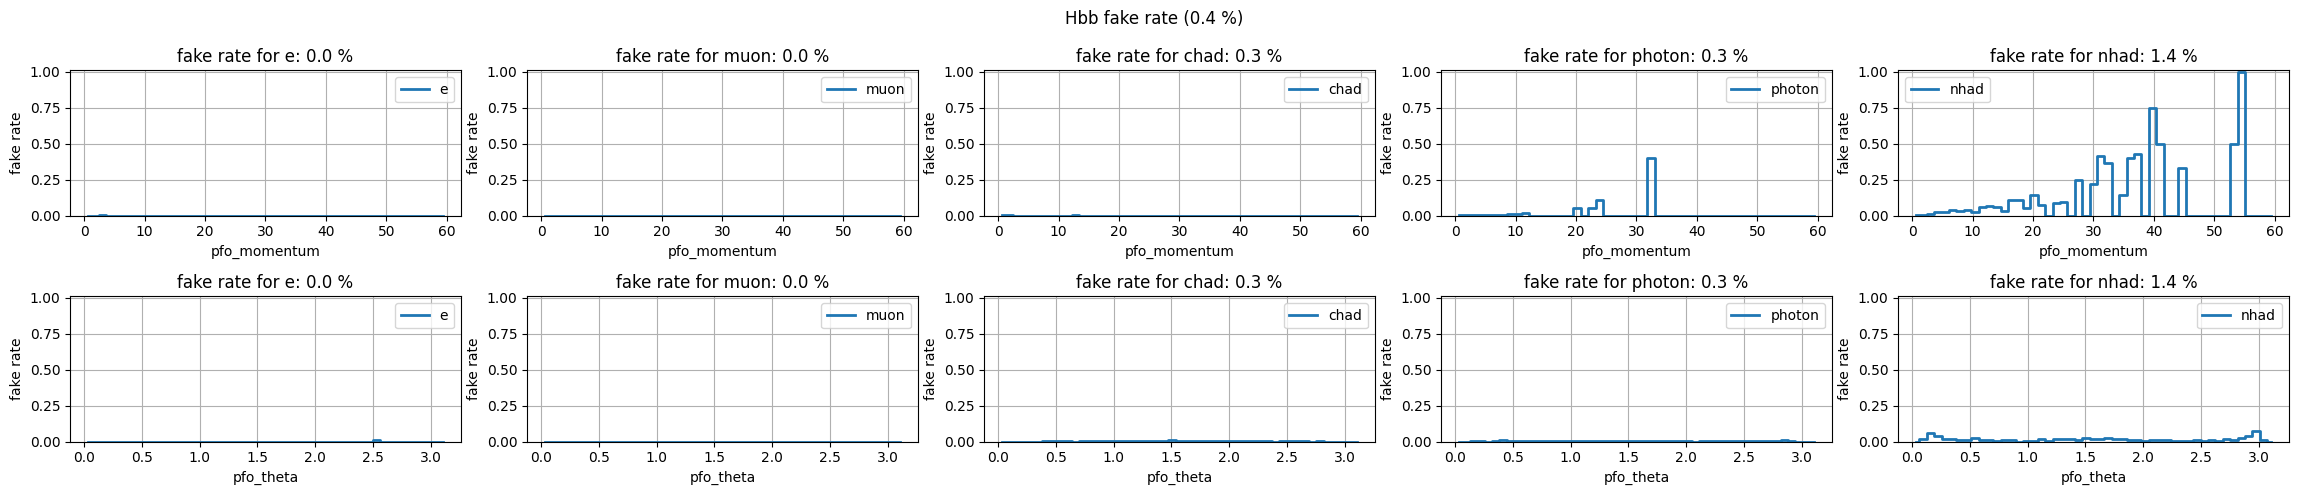

In [26]:
plot_fakerate("bb", save=save_status)

/tmp/ipykernel_109555/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


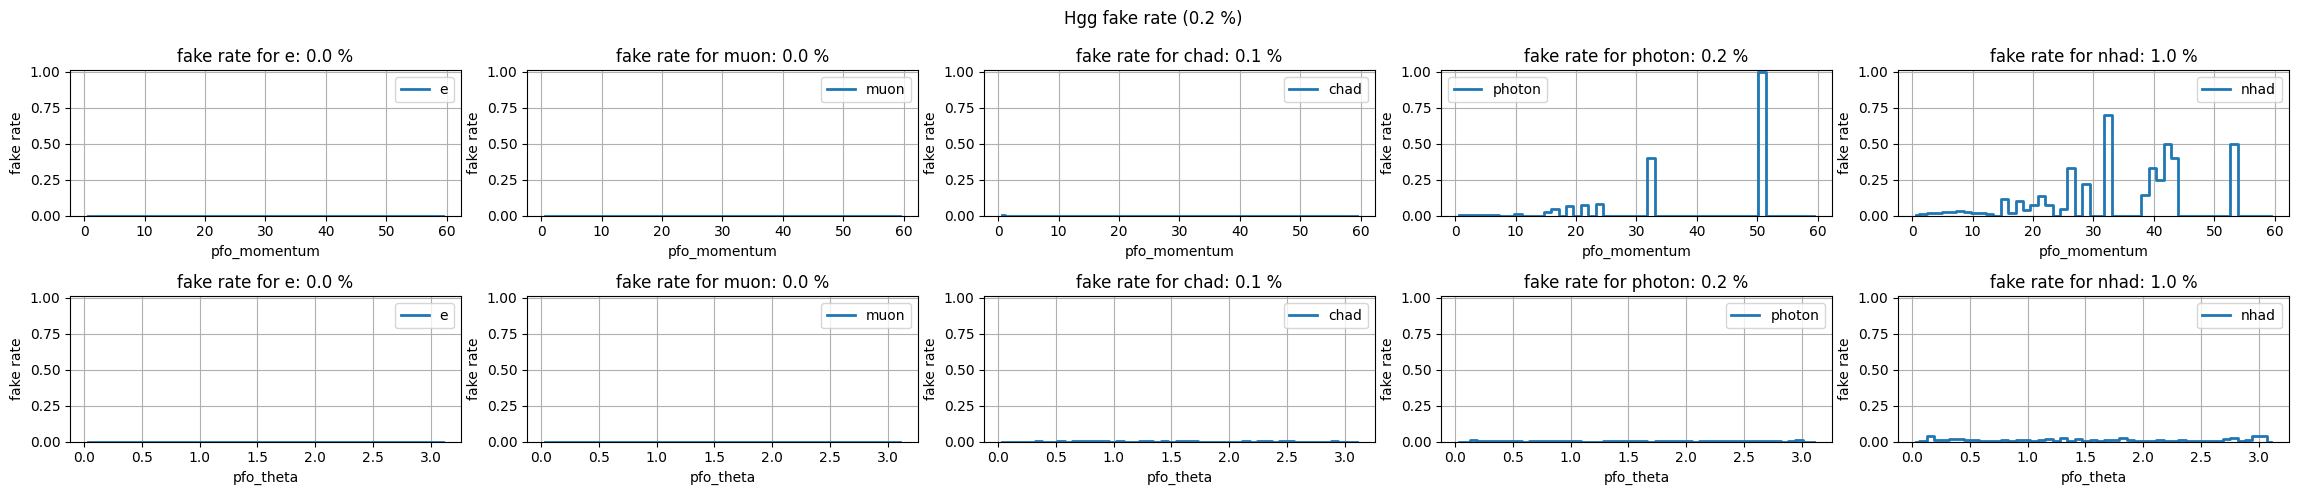

In [27]:
plot_fakerate("gg", save=save_status)

/tmp/ipykernel_109555/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


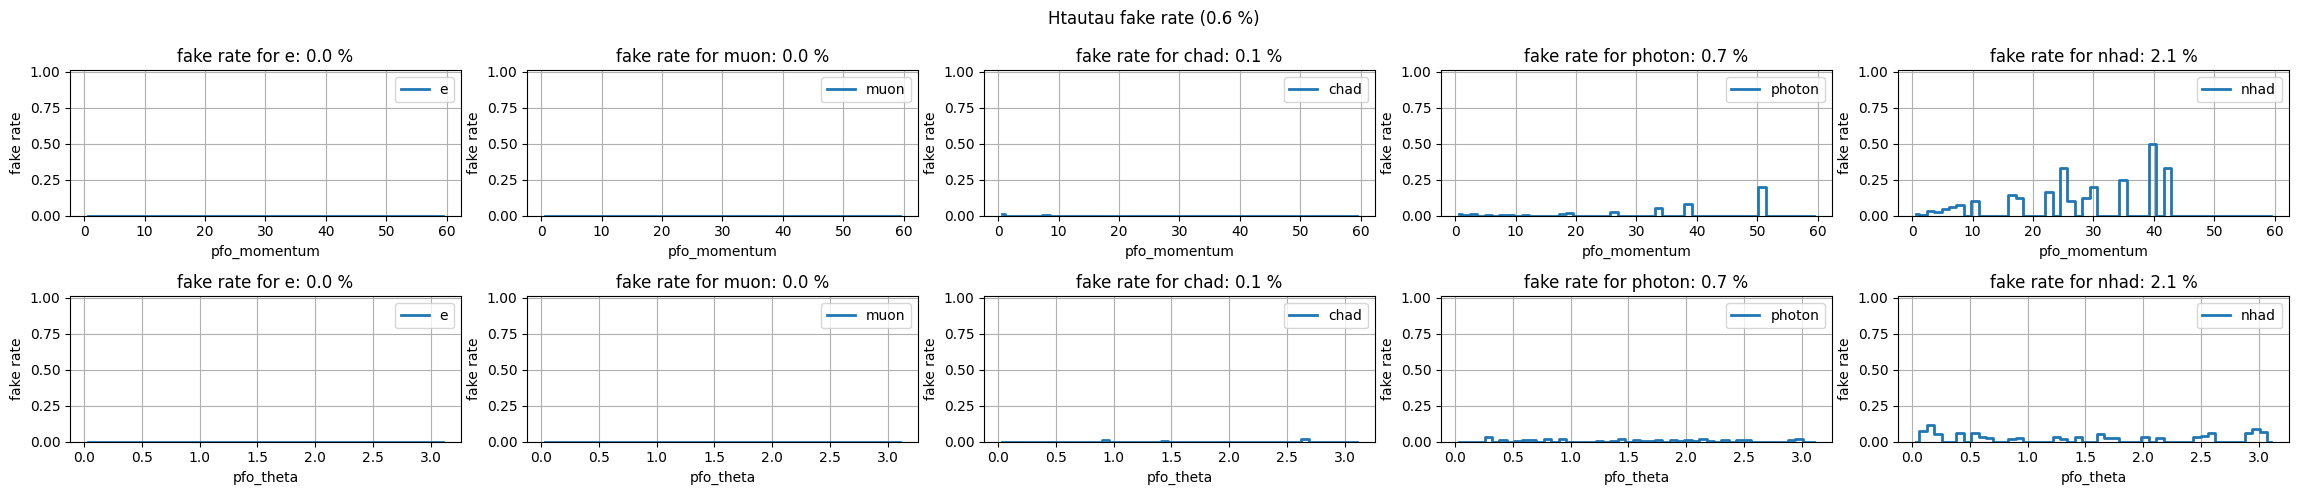

In [28]:
plot_fakerate("tautau", save=save_status)

Let's do all of them in one plot....

In [32]:
def plot_fakerate_joined(Htype, log_p = False, save=False):
    num_bins=50
    i_good_reco, i_wrong_reco = index_fake(Htype)
    i_ptype = ind_ptype(Htype)
    labels = ["e", "muon", "chad", "photon", "nhad"]
    ranges = [[0, 60], [0, 3.14]]
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"H{Htype} fake rate ({np.round(fake_rate(Htype)*100, 1)} %)")
    for j, obs in enumerate(["pfo_momentum", "pfo_theta"]):
        # Logarithmic binning for "momentum"
        if obs == "pfo_momentum": # and log_p:
            bins = np.logspace(np.log10(ranges[j][0]+1e-1), np.log10(ranges[j][1]), num_bins)
            ax[j].set_xscale("log")
        else:
            bins = np.linspace(ranges[j][0], ranges[j][1], num_bins)
            ax[j].set_xscale("linear")

        for i in range(5):
            ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[i_ptype[i]], range=ranges[j], bins=bins, density=False)
            
            ind_interest = np.intersect1d(i_wrong_reco, i_ptype[i])
            # plot
            obs_data = np.concatenate(dic[Htype][obs])[ind_interest]
            normalized_obs_data = normalize_hist(obs_data, ref_counts, bins, range=ranges[j])
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
            fakerate_ptype = fake_rate_x(Htype, i_ptype[i], ind_interest)
            #ax[j].set_title(f"fake rate for {labels[i]}: {np.round(fakerate_ptype*100, 1)} %")
            ax[j].plot(bin_centers, normalized_obs_data, drawstyle='steps-mid', linewidth=2.0, label=f"{labels[i]} ({np.round(fakerate_ptype*100, 2)} %)" )#, label=f"MC {xtype}, track ({effi[2]} %)")
            ax[j].set_xlabel(f"{obs}")
            ax[j].set_ylabel("fake rate")

            #ax[j].hist(np.concatenate(dic[Htype]["pfo_momentum"])[i_ptype[i]], bins=100, histtype='step', label=labels[i])
            ax[j].grid()
            ax[j].legend()
            ax[j].set_ylim(10e-5, 1)
            ax[j].set_yscale('log')
    if save:
        plt.savefig(f"./hist-trackPFOcheck-fakerate/fakerate_part_joined_H{Htype}.pdf")
    plt.tight_layout()
    plt.show()

In [33]:
save_status = False

/tmp/ipykernel_109555/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


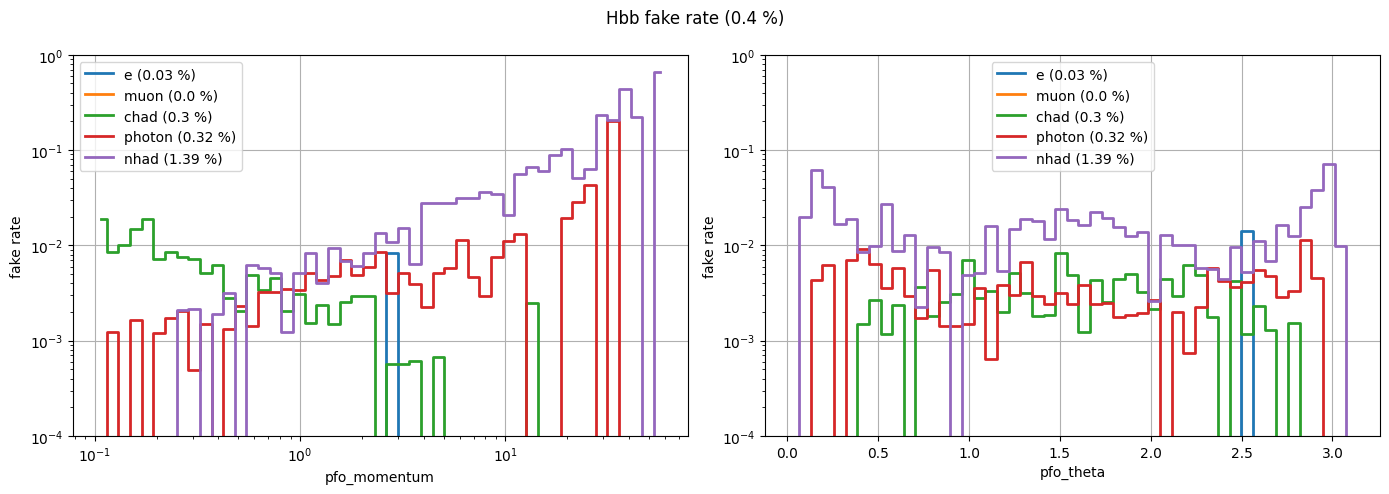

In [34]:
plot_fakerate_joined("bb", save=save_status)

/tmp/ipykernel_109555/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


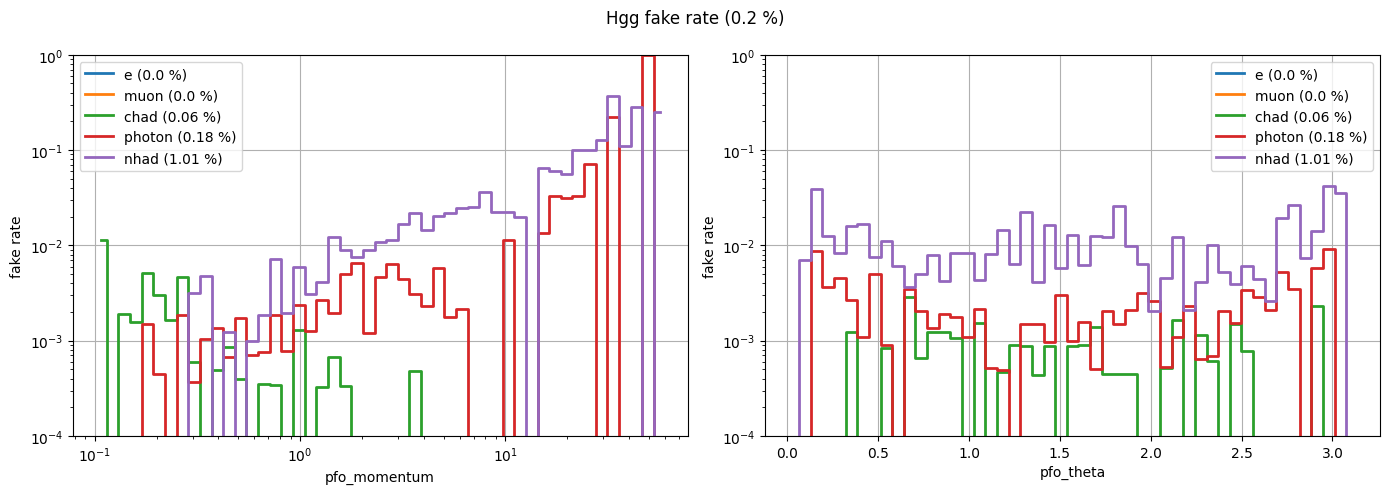

In [35]:
plot_fakerate_joined("gg", save=save_status)

/tmp/ipykernel_109555/1930759235.py:5: RuntimeWarning: invalid value encountered in divide
  normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)


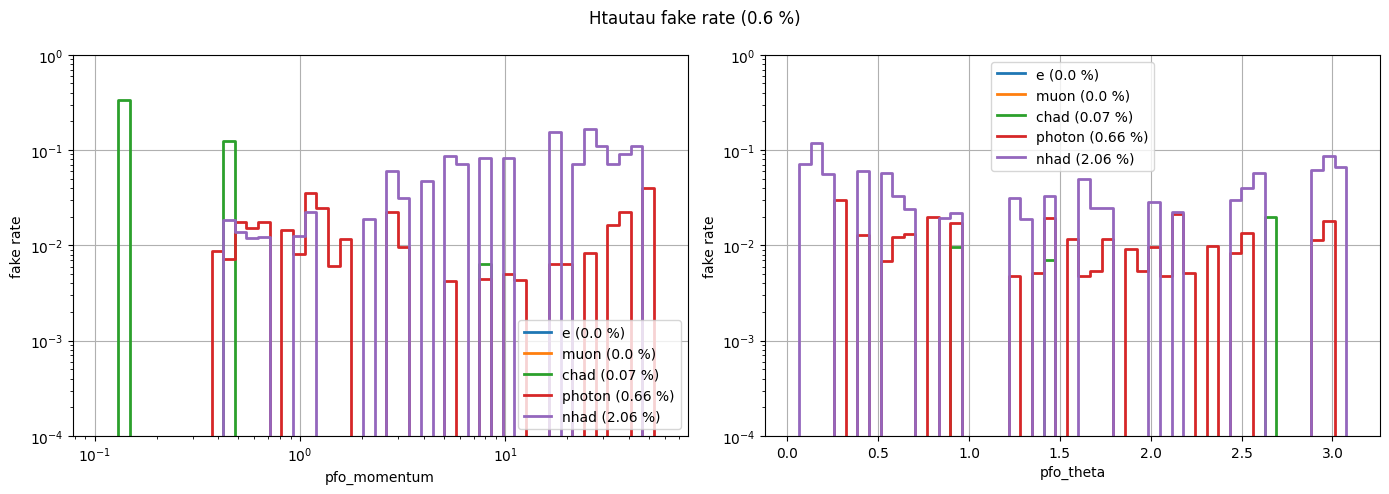

In [36]:
plot_fakerate_joined("tautau", save=save_status)

Fake rate (bb/gg/tautau): 2.9, 2.2, 3.3 % 

Fake rate nhad (bb/gg/tautau): 7.84, 6.88, 8.68 %

**Fake rate for min_frac = 0.5:**
bb/gg/tautau: 0.4/0.2/0.6 %